In [4]:
import numpy as np
import time
import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
import textwrap
from scipy.optimize import curve_fit
from pylabnet.network.client_server.si_tt import Client
import pylabnet.hardware.awg.zi_hdawg as zi_hdawg


class TuneUp():
    def __init__(self, hd=None,ctr=None):
        self.HDAWG = hd
        self.ctr = ctr

    def configure_eODMR(self, fstart=340, fstop=480, pts=141, f1=378e6, f2=442e6, p1=60, p2=60, ps=60, rp=20, trsh=10):
        
        self.max = fstop
        self.min = fstart
        self.freq_step = (fstop/0.5-fstart/0.5)/(pts-1)
        self.repeat_per_freq = int(rp)

        self.HDAWG = zi_hdawg.Driver('dev8354', None)

        # set stepping frequency
        self.HDAWG.setd('oscs/2/freq', 500000)

        # set DIO in AWG-controlled  mode
        self.HDAWG.seti('dios/0/mode', 1)

        # set oscillators in non-AWG-controlled mode
        self.HDAWG.seti('system/awg/oscillatorcontrol', 0)

        # set right waveform modulation mode
        self.HDAWG.seti('awgs/0/outputs/0/modulation/mode', 3)
        self.HDAWG.seti('awgs/1/outputs/0/modulation/mode', 3)

        # set IQ params (amps)
        amp_I = self.HDAWG.getd('sines/0/amplitudes/0')
        self.HDAWG.setd('awgs/0/outputs/0/gains/0', amp_I)
        self.HDAWG.setd('awgs/0/outputs/1/gains/0', amp_I)
        amp_Q = self.HDAWG.getd('sines/2/amplitudes/0')
        self.HDAWG.setd('awgs/1/outputs/0/gains/0', amp_Q)
        self.HDAWG.setd('awgs/1/outputs/1/gains/0', amp_Q)

        # Logic counter settings
        self.HDAWG.seti('cnts/0/enable', 1)
        self.HDAWG.seti('cnts/0/mode', 3)
        self.HDAWG.seti('cnts/0/inputselect', 35)
        self.HDAWG.seti('cnts/0/gateselect', 32)

        self.HDAWG.setd('oscs/0/freq', int(f1))
        self.HDAWG.setd('oscs/1/freq', int(f2))

        plugin = f"""
        const DIO8 = 0b00000000000000000000000100000000;
        const DIO9and10 = 0b00000000000000000010011000000000;
        const DIO10 = 0b00000000000000000010010000000000;
        const DIO11 = 0b00000000000000000010100000000000;
        const OFF = 0b00000000000000000010000000000000;

        var start_freq = {int(fstart/0.5)};
        var stop_freq = {int(fstop/0.5)};
        var freq_step = {int((fstop/0.5-fstart/0.5)/(pts-1))};


        const t_green = 500000;
        const t_TiSa = 250000;
        const pi1_pulse_dur = {int(p1)};
        const pi2_pulse_dur = {int(p2)};
        const RF_pulse_dur = {int(ps)};

        const repeat_per_freq = {int(rp)};

        const trsh = {int(trsh)};

        """

        constant = """

        const ionized_trsh = 100; // after how many repeats do we send the green laser?

        wave pi1_pulse = ones(pi1_pulse_dur);
        wave pi1_zero = zeros(pi1_pulse_dur);
        wave pi2_pulse = ones(pi2_pulse_dur);
        wave pi2_zero = zeros(pi2_pulse_dur);

        var el_perro_verde = 0;

        for (var i = start_freq; i <= stop_freq; i = i + freq_step) {

            repeat (repeat_per_freq){

                setTrigger(0b0001);
                setDIO(DIO10);
                wait(t_TiSa);
                setDIO(OFF);
                setTrigger(0b0000);
                wait(t_TiSa);

                while (getCnt(0) > trsh) {

                    if (el_perro_verde > ionized_trsh) {
                        setDIO(DIO11);
                        wait(t_green);
                        setDIO(OFF);
                        wait(t_green);

                        el_perro_verde = 0;
                    }
                    setInt('sines/0/oscselect', 0);
                    setInt('sines/2/oscselect', 0);
                    setInt('sines/0/harmonic', 1);
                    setInt('sines/2/harmonic', 1);

                    setDIO(DIO8);
                    wait(10);
                    playWave(1, pi1_pulse, 1, pi1_zero, 3, pi1_pulse, 3, pi1_zero); //1st pi pulse
                    waitWave();
                    wait(10);
                    setDIO(OFF);

                    wait(t_TiSa);

                    setDIO(DIO8);
                    wait(10);
                    playWave(1, pi2_zero, 1, pi2_pulse, 3, pi2_zero, 3, pi2_pulse); //2nd pi pulse
                    waitWave();
                    wait(10);
                    setDIO(OFF);

                    wait(t_TiSa);

                    setTrigger(0b0001);
                    setDIO(DIO10);
                    wait(t_TiSa);
                    setDIO(OFF);
                    setTrigger(0b0000);
                    wait(t_TiSa);

                    el_perro_verde += 1;

                }

                el_perro_verde = 0;

                setInt('sines/0/harmonic', i);
                setInt('sines/2/harmonic', i);
                setInt('sines/0/oscselect', 2);
                setInt('sines/2/oscselect', 2);

                setDIO(DIO8);
                wait(10);
                playWave(1, pi1_pulse, 1, pi1_zero, 3, pi1_pulse, 3, pi1_zero); //1st pi pulse
                waitWave();
                wait(10);
                setDIO(OFF);
                wait(t_TiSa);

                setDIO(DIO9and10);
                wait(t_TiSa);
                setDIO(OFF);
                wait(t_TiSa);

            }

        }


        """

        self.awgModule = self.HDAWG.daq.awgModule()
        self.awgModule.set("device", self.HDAWG.device_id)
        self.awgModule.execute()

        self.awgModule.set("compiler/sourcestring", textwrap.dedent(plugin+constant))
        time.sleep(3)

        # Ctr 5 gated
        self.ctr.start_gated_counter(
            name='gated_5',
            click_ch=5,
            gate_ch=6,
            bins=pts*self.repeat_per_freq
        )

        self.FLAG = True
        self.ON = False

    def experiment_eODMR(self, frequency):
        if self.FLAG:
            time.sleep(0.1)
            if not self.HDAWG.geti('awgs/0/enable'):
                self.HDAWG.seti('awgs/0/enable', 1)
                self.FLAG = False
                time.sleep(0.1)
                self.ON = True
                self.measured = False


        while self.ON:
            self.ON = self.HDAWG.geti('awgs/0/enable')

        if not self.measured:
            self.measurement = self.ctr.get_counts(name='gated_5')
            self.measured = True

        i = int((frequency/0.5-self.min/0.5)/self.freq_step)

        i = self.repeat_per_freq*i

        if frequency == self.max:
            self.FLAG = True
            self.ctr.clear_ctr(name='gated_5')

        return np.mean(self.measurement[i:(i+self.repeat_per_freq)])

    def configure_eRABI(self, tstart=0, tstop=255, pts=32, f1=378e6, f2=442e6, p1=60, p2=60, rp=40, trsh=10):
    
        self.max = tstop
        self.min = tstart
        self.time_step = (tstop-tstart)/(pts-1)
        self.repeat_per_time = int(rp)

        self.HDAWG = zi_hdawg.Driver('dev8354', None)

        # set DIO in AWG-controlled  mode
        self.HDAWG.seti('dios/0/mode', 1)

        # set oscillators in AWG-controlled mode
        self.HDAWG.seti('system/awg/oscillatorcontrol', 0)

        # set right oscillators
        self.HDAWG.seti('sines/0/oscselect', 0)
        self.HDAWG.seti('sines/1/oscselect', 1)
        self.HDAWG.seti('sines/2/oscselect', 0)
        self.HDAWG.seti('sines/3/oscselect', 1)

        # set right harmonic
        self.HDAWG.seti('sines/0/harmonic', 1)
        self.HDAWG.seti('sines/2/harmonic', 1)

        # set right waveform modulation mode
        self.HDAWG.seti('awgs/0/outputs/0/modulation/mode', 3)
        self.HDAWG.seti('awgs/1/outputs/0/modulation/mode', 3)

        # set IQ params (amps)
        amp_I = self.HDAWG.getd('sines/0/amplitudes/0')
        self.HDAWG.setd('awgs/0/outputs/0/gains/0', amp_I)
        self.HDAWG.setd('awgs/0/outputs/1/gains/0', amp_I)
        amp_Q = self.HDAWG.getd('sines/2/amplitudes/0')
        self.HDAWG.setd('awgs/1/outputs/0/gains/0', amp_Q)
        self.HDAWG.setd('awgs/1/outputs/1/gains/0', amp_Q)

        # Logic counter settings
        self.HDAWG.seti('cnts/0/enable', 1)
        self.HDAWG.seti('cnts/0/mode', 3)
        self.HDAWG.seti('cnts/0/inputselect', 35)
        self.HDAWG.seti('cnts/0/gateselect', 32)

        self.HDAWG.setd('oscs/0/freq', int(f1))
        self.HDAWG.setd('oscs/1/freq', int(f2))

        plugin = f"""
        const DIO8 = 0b00000000000000000000000100000000;
        const DIO9and10 = 0b00000000000000000010011000000000;
        const DIO10 = 0b00000000000000000010010000000000;
        const DIO11 = 0b00000000000000000010100000000000;
        const OFF = 0b00000000000000000010000000000000;



        var start_time = {int(tstart)};
        var stop_time = {int(tstop)};
        var time_step = {int((tstop-tstart)/(pts-1))};


        const t_green = 500000;
        const t_TiSa = 250000;
        const pi1_pulse_dur = {int(p1)};
        const pi2_pulse_dur = {int(p2)};

        const repeat_per_time = {int(rp)};

        const trsh = {int(trsh)};

        """

        constant = """

        const ionized_trsh = 100; // after how many repeats do we send the green laser?

        wave pi1_pulse = ones(pi1_pulse_dur);
        wave pi1_zero = zeros(pi1_pulse_dur);
        wave pi2_pulse = ones(pi2_pulse_dur);
        wave pi2_zero = zeros(pi2_pulse_dur);

        void variable_length_pulse_p1 (var i) {
            switch(i) {
                case 0:
                    playWave(1, "waveform_length_0", 1, zeros(256), 3, "waveform_length_0", 3, zeros(256));
                    waitWave();
                case 1:
                    playWave(1, "waveform_length_1", 1, zeros(256), 3, "waveform_length_1", 3, zeros(256));
                    waitWave();
                case 2:
                    playWave(1, "waveform_length_2", 1, zeros(256), 3, "waveform_length_2", 3, zeros(256));
                    waitWave();
                case 3:
                    playWave(1, "waveform_length_3", 1, zeros(256), 3, "waveform_length_3", 3, zeros(256));
                    waitWave();
                case 4:
                    playWave(1, "waveform_length_4", 1, zeros(256), 3, "waveform_length_4", 3, zeros(256));
                    waitWave();
                case 5:
                    playWave(1, "waveform_length_5", 1, zeros(256), 3, "waveform_length_5", 3, zeros(256));
                    waitWave();
                case 6:
                    playWave(1, "waveform_length_6", 1, zeros(256), 3, "waveform_length_6", 3, zeros(256));
                    waitWave();
                case 7:
                    playWave(1, "waveform_length_7", 1, zeros(256), 3, "waveform_length_7", 3, zeros(256));
                    waitWave();
                case 8:
                    playWave(1, "waveform_length_8", 1, zeros(256), 3, "waveform_length_8", 3, zeros(256));
                    waitWave();
                case 9:
                    playWave(1, "waveform_length_9", 1, zeros(256), 3, "waveform_length_9", 3, zeros(256));
                    waitWave();
                case 10:
                    playWave(1, "waveform_length_10", 1, zeros(256), 3, "waveform_length_10", 3, zeros(256));
                    waitWave();
                case 11:
                    playWave(1, "waveform_length_11", 1, zeros(256), 3, "waveform_length_11", 3, zeros(256));
                    waitWave();
                case 12:
                    playWave(1, "waveform_length_12", 1, zeros(256), 3, "waveform_length_12", 3, zeros(256));
                    waitWave();
                case 13:
                    playWave(1, "waveform_length_13", 1, zeros(256), 3, "waveform_length_13", 3, zeros(256));
                    waitWave();
                case 14:
                    playWave(1, "waveform_length_14", 1, zeros(256), 3, "waveform_length_14", 3, zeros(256));
                    waitWave();
                case 15:
                    playWave(1, "waveform_length_15", 1, zeros(256), 3, "waveform_length_15", 3, zeros(256));
                    waitWave();
                case 16:
                    playWave(1, "waveform_length_16", 1, zeros(256), 3, "waveform_length_16", 3, zeros(256));
                    waitWave();
                case 17:
                    playWave(1, "waveform_length_17", 1, zeros(256), 3, "waveform_length_17", 3, zeros(256));
                    waitWave();
                case 18:
                    playWave(1, "waveform_length_18", 1, zeros(256), 3, "waveform_length_18", 3, zeros(256));
                    waitWave();
                case 19:
                    playWave(1, "waveform_length_19", 1, zeros(256), 3, "waveform_length_19", 3, zeros(256));
                    waitWave();
                case 20:
                    playWave(1, "waveform_length_20", 1, zeros(256), 3, "waveform_length_20", 3, zeros(256));
                    waitWave();
                case 21:
                    playWave(1, "waveform_length_21", 1, zeros(256), 3, "waveform_length_21", 3, zeros(256));
                    waitWave();
                case 22:
                    playWave(1, "waveform_length_22", 1, zeros(256), 3, "waveform_length_22", 3, zeros(256));
                    waitWave();
                case 23:
                    playWave(1, "waveform_length_23", 1, zeros(256), 3, "waveform_length_23", 3, zeros(256));
                    waitWave();
                case 24:
                    playWave(1, "waveform_length_24", 1, zeros(256), 3, "waveform_length_24", 3, zeros(256));
                    waitWave();
                case 25:
                    playWave(1, "waveform_length_25", 1, zeros(256), 3, "waveform_length_25", 3, zeros(256));
                    waitWave();
                case 26:
                    playWave(1, "waveform_length_26", 1, zeros(256), 3, "waveform_length_26", 3, zeros(256));
                    waitWave();
                case 27:
                    playWave(1, "waveform_length_27", 1, zeros(256), 3, "waveform_length_27", 3, zeros(256));
                    waitWave();
                case 28:
                    playWave(1, "waveform_length_28", 1, zeros(256), 3, "waveform_length_28", 3, zeros(256));
                    waitWave();
                case 29:
                    playWave(1, "waveform_length_29", 1, zeros(256), 3, "waveform_length_29", 3, zeros(256));
                    waitWave();
                case 30:
                    playWave(1, "waveform_length_30", 1, zeros(256), 3, "waveform_length_30", 3, zeros(256));
                    waitWave();
                case 31:
                    playWave(1, "waveform_length_31", 1, zeros(256), 3, "waveform_length_31", 3, zeros(256));
                    waitWave();
                case 32:
                    playWave(1, "waveform_length_32", 1, zeros(256), 3, "waveform_length_32", 3, zeros(256));
                    waitWave();
                case 33:
                    playWave(1, "waveform_length_33", 1, zeros(256), 3, "waveform_length_33", 3, zeros(256));
                    waitWave();
                case 34:
                    playWave(1, "waveform_length_34", 1, zeros(256), 3, "waveform_length_34", 3, zeros(256));
                    waitWave();
                case 35:
                    playWave(1, "waveform_length_35", 1, zeros(256), 3, "waveform_length_35", 3, zeros(256));
                    waitWave();
                case 36:
                    playWave(1, "waveform_length_36", 1, zeros(256), 3, "waveform_length_36", 3, zeros(256));
                    waitWave();
                case 37:
                    playWave(1, "waveform_length_37", 1, zeros(256), 3, "waveform_length_37", 3, zeros(256));
                    waitWave();
                case 38:
                    playWave(1, "waveform_length_38", 1, zeros(256), 3, "waveform_length_38", 3, zeros(256));
                    waitWave();
                case 39:
                    playWave(1, "waveform_length_39", 1, zeros(256), 3, "waveform_length_39", 3, zeros(256));
                    waitWave();
                case 40:
                    playWave(1, "waveform_length_40", 1, zeros(256), 3, "waveform_length_40", 3, zeros(256));
                    waitWave();
                case 41:
                    playWave(1, "waveform_length_41", 1, zeros(256), 3, "waveform_length_41", 3, zeros(256));
                    waitWave();
                case 42:
                    playWave(1, "waveform_length_42", 1, zeros(256), 3, "waveform_length_42", 3, zeros(256));
                    waitWave();
                case 43:
                    playWave(1, "waveform_length_43", 1, zeros(256), 3, "waveform_length_43", 3, zeros(256));
                    waitWave();
                case 44:
                    playWave(1, "waveform_length_44", 1, zeros(256), 3, "waveform_length_44", 3, zeros(256));
                    waitWave();
                case 45:
                    playWave(1, "waveform_length_45", 1, zeros(256), 3, "waveform_length_45", 3, zeros(256));
                    waitWave();
                case 46:
                    playWave(1, "waveform_length_46", 1, zeros(256), 3, "waveform_length_46", 3, zeros(256));
                    waitWave();
                case 47:
                    playWave(1, "waveform_length_47", 1, zeros(256), 3, "waveform_length_47", 3, zeros(256));
                    waitWave();
                case 48:
                    playWave(1, "waveform_length_48", 1, zeros(256), 3, "waveform_length_48", 3, zeros(256));
                    waitWave();
                case 49:
                    playWave(1, "waveform_length_49", 1, zeros(256), 3, "waveform_length_49", 3, zeros(256));
                    waitWave();
                case 50:
                    playWave(1, "waveform_length_50", 1, zeros(256), 3, "waveform_length_50", 3, zeros(256));
                    waitWave();
                case 51:
                    playWave(1, "waveform_length_51", 1, zeros(256), 3, "waveform_length_51", 3, zeros(256));
                    waitWave();
                case 52:
                    playWave(1, "waveform_length_52", 1, zeros(256), 3, "waveform_length_52", 3, zeros(256));
                    waitWave();
                case 53:
                    playWave(1, "waveform_length_53", 1, zeros(256), 3, "waveform_length_53", 3, zeros(256));
                    waitWave();
                case 54:
                    playWave(1, "waveform_length_54", 1, zeros(256), 3, "waveform_length_54", 3, zeros(256));
                    waitWave();
                case 55:
                    playWave(1, "waveform_length_55", 1, zeros(256), 3, "waveform_length_55", 3, zeros(256));
                    waitWave();
                case 56:
                    playWave(1, "waveform_length_56", 1, zeros(256), 3, "waveform_length_56", 3, zeros(256));
                    waitWave();
                case 57:
                    playWave(1, "waveform_length_57", 1, zeros(256), 3, "waveform_length_57", 3, zeros(256));
                    waitWave();
                case 58:
                    playWave(1, "waveform_length_58", 1, zeros(256), 3, "waveform_length_58", 3, zeros(256));
                    waitWave();
                case 59:
                    playWave(1, "waveform_length_59", 1, zeros(256), 3, "waveform_length_59", 3, zeros(256));
                    waitWave();
                case 60:
                    playWave(1, "waveform_length_60", 1, zeros(256), 3, "waveform_length_60", 3, zeros(256));
                    waitWave();
                case 61:
                    playWave(1, "waveform_length_61", 1, zeros(256), 3, "waveform_length_61", 3, zeros(256));
                    waitWave();
                case 62:
                    playWave(1, "waveform_length_62", 1, zeros(256), 3, "waveform_length_62", 3, zeros(256));
                    waitWave();
                case 63:
                    playWave(1, "waveform_length_63", 1, zeros(256), 3, "waveform_length_63", 3, zeros(256));
                    waitWave();
                case 64:
                    playWave(1, "waveform_length_64", 1, zeros(256), 3, "waveform_length_64", 3, zeros(256));
                    waitWave();
                case 65:
                    playWave(1, "waveform_length_65", 1, zeros(256), 3, "waveform_length_65", 3, zeros(256));
                    waitWave();
                case 66:
                    playWave(1, "waveform_length_66", 1, zeros(256), 3, "waveform_length_66", 3, zeros(256));
                    waitWave();
                case 67:
                    playWave(1, "waveform_length_67", 1, zeros(256), 3, "waveform_length_67", 3, zeros(256));
                    waitWave();
                case 68:
                    playWave(1, "waveform_length_68", 1, zeros(256), 3, "waveform_length_68", 3, zeros(256));
                    waitWave();
                case 69:
                    playWave(1, "waveform_length_69", 1, zeros(256), 3, "waveform_length_69", 3, zeros(256));
                    waitWave();
                case 70:
                    playWave(1, "waveform_length_70", 1, zeros(256), 3, "waveform_length_70", 3, zeros(256));
                    waitWave();
                case 71:
                    playWave(1, "waveform_length_71", 1, zeros(256), 3, "waveform_length_71", 3, zeros(256));
                    waitWave();
                case 72:
                    playWave(1, "waveform_length_72", 1, zeros(256), 3, "waveform_length_72", 3, zeros(256));
                    waitWave();
                case 73:
                    playWave(1, "waveform_length_73", 1, zeros(256), 3, "waveform_length_73", 3, zeros(256));
                    waitWave();
                case 74:
                    playWave(1, "waveform_length_74", 1, zeros(256), 3, "waveform_length_74", 3, zeros(256));
                    waitWave();
                case 75:
                    playWave(1, "waveform_length_75", 1, zeros(256), 3, "waveform_length_75", 3, zeros(256));
                    waitWave();
                case 76:
                    playWave(1, "waveform_length_76", 1, zeros(256), 3, "waveform_length_76", 3, zeros(256));
                    waitWave();
                case 77:
                    playWave(1, "waveform_length_77", 1, zeros(256), 3, "waveform_length_77", 3, zeros(256));
                    waitWave();
                case 78:
                    playWave(1, "waveform_length_78", 1, zeros(256), 3, "waveform_length_78", 3, zeros(256));
                    waitWave();
                case 79:
                    playWave(1, "waveform_length_79", 1, zeros(256), 3, "waveform_length_79", 3, zeros(256));
                    waitWave();
                case 80:
                    playWave(1, "waveform_length_80", 1, zeros(256), 3, "waveform_length_80", 3, zeros(256));
                    waitWave();
                case 81:
                    playWave(1, "waveform_length_81", 1, zeros(256), 3, "waveform_length_81", 3, zeros(256));
                    waitWave();
                case 82:
                    playWave(1, "waveform_length_82", 1, zeros(256), 3, "waveform_length_82", 3, zeros(256));
                    waitWave();
                case 83:
                    playWave(1, "waveform_length_83", 1, zeros(256), 3, "waveform_length_83", 3, zeros(256));
                    waitWave();
                case 84:
                    playWave(1, "waveform_length_84", 1, zeros(256), 3, "waveform_length_84", 3, zeros(256));
                    waitWave();
                case 85:
                    playWave(1, "waveform_length_85", 1, zeros(256), 3, "waveform_length_85", 3, zeros(256));
                    waitWave();
                case 86:
                    playWave(1, "waveform_length_86", 1, zeros(256), 3, "waveform_length_86", 3, zeros(256));
                    waitWave();
                case 87:
                    playWave(1, "waveform_length_87", 1, zeros(256), 3, "waveform_length_87", 3, zeros(256));
                    waitWave();
                case 88:
                    playWave(1, "waveform_length_88", 1, zeros(256), 3, "waveform_length_88", 3, zeros(256));
                    waitWave();
                case 89:
                    playWave(1, "waveform_length_89", 1, zeros(256), 3, "waveform_length_89", 3, zeros(256));
                    waitWave();
                case 90:
                    playWave(1, "waveform_length_90", 1, zeros(256), 3, "waveform_length_90", 3, zeros(256));
                    waitWave();
                case 91:
                    playWave(1, "waveform_length_91", 1, zeros(256), 3, "waveform_length_91", 3, zeros(256));
                    waitWave();
                case 92:
                    playWave(1, "waveform_length_92", 1, zeros(256), 3, "waveform_length_92", 3, zeros(256));
                    waitWave();
                case 93:
                    playWave(1, "waveform_length_93", 1, zeros(256), 3, "waveform_length_93", 3, zeros(256));
                    waitWave();
                case 94:
                    playWave(1, "waveform_length_94", 1, zeros(256), 3, "waveform_length_94", 3, zeros(256));
                    waitWave();
                case 95:
                    playWave(1, "waveform_length_95", 1, zeros(256), 3, "waveform_length_95", 3, zeros(256));
                    waitWave();
                case 96:
                    playWave(1, "waveform_length_96", 1, zeros(256), 3, "waveform_length_96", 3, zeros(256));
                    waitWave();
                case 97:
                    playWave(1, "waveform_length_97", 1, zeros(256), 3, "waveform_length_97", 3, zeros(256));
                    waitWave();
                case 98:
                    playWave(1, "waveform_length_98", 1, zeros(256), 3, "waveform_length_98", 3, zeros(256));
                    waitWave();
                case 99:
                    playWave(1, "waveform_length_99", 1, zeros(256), 3, "waveform_length_99", 3, zeros(256));
                    waitWave();
                case 100:
                    playWave(1, "waveform_length_100", 1, zeros(256), 3, "waveform_length_100", 3, zeros(256));
                    waitWave();
                case 101:
                    playWave(1, "waveform_length_101", 1, zeros(256), 3, "waveform_length_101", 3, zeros(256));
                    waitWave();
                case 102:
                    playWave(1, "waveform_length_102", 1, zeros(256), 3, "waveform_length_102", 3, zeros(256));
                    waitWave();
                case 103:
                    playWave(1, "waveform_length_103", 1, zeros(256), 3, "waveform_length_103", 3, zeros(256));
                    waitWave();
                case 104:
                    playWave(1, "waveform_length_104", 1, zeros(256), 3, "waveform_length_104", 3, zeros(256));
                    waitWave();
                case 105:
                    playWave(1, "waveform_length_105", 1, zeros(256), 3, "waveform_length_105", 3, zeros(256));
                    waitWave();
                case 106:
                    playWave(1, "waveform_length_106", 1, zeros(256), 3, "waveform_length_106", 3, zeros(256));
                    waitWave();
                case 107:
                    playWave(1, "waveform_length_107", 1, zeros(256), 3, "waveform_length_107", 3, zeros(256));
                    waitWave();
                case 108:
                    playWave(1, "waveform_length_108", 1, zeros(256), 3, "waveform_length_108", 3, zeros(256));
                    waitWave();
                case 109:
                    playWave(1, "waveform_length_109", 1, zeros(256), 3, "waveform_length_109", 3, zeros(256));
                    waitWave();
                case 110:
                    playWave(1, "waveform_length_110", 1, zeros(256), 3, "waveform_length_110", 3, zeros(256));
                    waitWave();
                case 111:
                    playWave(1, "waveform_length_111", 1, zeros(256), 3, "waveform_length_111", 3, zeros(256));
                    waitWave();
                case 112:
                    playWave(1, "waveform_length_112", 1, zeros(256), 3, "waveform_length_112", 3, zeros(256));
                    waitWave();
                case 113:
                    playWave(1, "waveform_length_113", 1, zeros(256), 3, "waveform_length_113", 3, zeros(256));
                    waitWave();
                case 114:
                    playWave(1, "waveform_length_114", 1, zeros(256), 3, "waveform_length_114", 3, zeros(256));
                    waitWave();
                case 115:
                    playWave(1, "waveform_length_115", 1, zeros(256), 3, "waveform_length_115", 3, zeros(256));
                    waitWave();
                case 116:
                    playWave(1, "waveform_length_116", 1, zeros(256), 3, "waveform_length_116", 3, zeros(256));
                    waitWave();
                case 117:
                    playWave(1, "waveform_length_117", 1, zeros(256), 3, "waveform_length_117", 3, zeros(256));
                    waitWave();
                case 118:
                    playWave(1, "waveform_length_118", 1, zeros(256), 3, "waveform_length_118", 3, zeros(256));
                    waitWave();
                case 119:
                    playWave(1, "waveform_length_119", 1, zeros(256), 3, "waveform_length_119", 3, zeros(256));
                    waitWave();
                case 120:
                    playWave(1, "waveform_length_120", 1, zeros(256), 3, "waveform_length_120", 3, zeros(256));
                    waitWave();
                case 121:
                    playWave(1, "waveform_length_121", 1, zeros(256), 3, "waveform_length_121", 3, zeros(256));
                    waitWave();
                case 122:
                    playWave(1, "waveform_length_122", 1, zeros(256), 3, "waveform_length_122", 3, zeros(256));
                    waitWave();
                case 123:
                    playWave(1, "waveform_length_123", 1, zeros(256), 3, "waveform_length_123", 3, zeros(256));
                    waitWave();
                case 124:
                    playWave(1, "waveform_length_124", 1, zeros(256), 3, "waveform_length_124", 3, zeros(256));
                    waitWave();
                case 125:
                    playWave(1, "waveform_length_125", 1, zeros(256), 3, "waveform_length_125", 3, zeros(256));
                    waitWave();
                case 126:
                    playWave(1, "waveform_length_126", 1, zeros(256), 3, "waveform_length_126", 3, zeros(256));
                    waitWave();
                case 127:
                    playWave(1, "waveform_length_127", 1, zeros(256), 3, "waveform_length_127", 3, zeros(256));
                    waitWave();
                case 128:
                    playWave(1, "waveform_length_128", 1, zeros(256), 3, "waveform_length_128", 3, zeros(256));
                    waitWave();
                case 129:
                    playWave(1, "waveform_length_129", 1, zeros(256), 3, "waveform_length_129", 3, zeros(256));
                    waitWave();
                case 130:
                    playWave(1, "waveform_length_130", 1, zeros(256), 3, "waveform_length_130", 3, zeros(256));
                    waitWave();
                case 131:
                    playWave(1, "waveform_length_131", 1, zeros(256), 3, "waveform_length_131", 3, zeros(256));
                    waitWave();
                case 132:
                    playWave(1, "waveform_length_132", 1, zeros(256), 3, "waveform_length_132", 3, zeros(256));
                    waitWave();
                case 133:
                    playWave(1, "waveform_length_133", 1, zeros(256), 3, "waveform_length_133", 3, zeros(256));
                    waitWave();
                case 134:
                    playWave(1, "waveform_length_134", 1, zeros(256), 3, "waveform_length_134", 3, zeros(256));
                    waitWave();
                case 135:
                    playWave(1, "waveform_length_135", 1, zeros(256), 3, "waveform_length_135", 3, zeros(256));
                    waitWave();
                case 136:
                    playWave(1, "waveform_length_136", 1, zeros(256), 3, "waveform_length_136", 3, zeros(256));
                    waitWave();
                case 137:
                    playWave(1, "waveform_length_137", 1, zeros(256), 3, "waveform_length_137", 3, zeros(256));
                    waitWave();
                case 138:
                    playWave(1, "waveform_length_138", 1, zeros(256), 3, "waveform_length_138", 3, zeros(256));
                    waitWave();
                case 139:
                    playWave(1, "waveform_length_139", 1, zeros(256), 3, "waveform_length_139", 3, zeros(256));
                    waitWave();
                case 140:
                    playWave(1, "waveform_length_140", 1, zeros(256), 3, "waveform_length_140", 3, zeros(256));
                    waitWave();
                case 141:
                    playWave(1, "waveform_length_141", 1, zeros(256), 3, "waveform_length_141", 3, zeros(256));
                    waitWave();
                case 142:
                    playWave(1, "waveform_length_142", 1, zeros(256), 3, "waveform_length_142", 3, zeros(256));
                    waitWave();
                case 143:
                    playWave(1, "waveform_length_143", 1, zeros(256), 3, "waveform_length_143", 3, zeros(256));
                    waitWave();
                case 144:
                    playWave(1, "waveform_length_144", 1, zeros(256), 3, "waveform_length_144", 3, zeros(256));
                    waitWave();
                case 145:
                    playWave(1, "waveform_length_145", 1, zeros(256), 3, "waveform_length_145", 3, zeros(256));
                    waitWave();
                case 146:
                    playWave(1, "waveform_length_146", 1, zeros(256), 3, "waveform_length_146", 3, zeros(256));
                    waitWave();
                case 147:
                    playWave(1, "waveform_length_147", 1, zeros(256), 3, "waveform_length_147", 3, zeros(256));
                    waitWave();
                case 148:
                    playWave(1, "waveform_length_148", 1, zeros(256), 3, "waveform_length_148", 3, zeros(256));
                    waitWave();
                case 149:
                    playWave(1, "waveform_length_149", 1, zeros(256), 3, "waveform_length_149", 3, zeros(256));
                    waitWave();
                case 150:
                    playWave(1, "waveform_length_150", 1, zeros(256), 3, "waveform_length_150", 3, zeros(256));
                    waitWave();
                case 151:
                    playWave(1, "waveform_length_151", 1, zeros(256), 3, "waveform_length_151", 3, zeros(256));
                    waitWave();
                case 152:
                    playWave(1, "waveform_length_152", 1, zeros(256), 3, "waveform_length_152", 3, zeros(256));
                    waitWave();
                case 153:
                    playWave(1, "waveform_length_153", 1, zeros(256), 3, "waveform_length_153", 3, zeros(256));
                    waitWave();
                case 154:
                    playWave(1, "waveform_length_154", 1, zeros(256), 3, "waveform_length_154", 3, zeros(256));
                    waitWave();
                case 155:
                    playWave(1, "waveform_length_155", 1, zeros(256), 3, "waveform_length_155", 3, zeros(256));
                    waitWave();
                case 156:
                    playWave(1, "waveform_length_156", 1, zeros(256), 3, "waveform_length_156", 3, zeros(256));
                    waitWave();
                case 157:
                    playWave(1, "waveform_length_157", 1, zeros(256), 3, "waveform_length_157", 3, zeros(256));
                    waitWave();
                case 158:
                    playWave(1, "waveform_length_158", 1, zeros(256), 3, "waveform_length_158", 3, zeros(256));
                    waitWave();
                case 159:
                    playWave(1, "waveform_length_159", 1, zeros(256), 3, "waveform_length_159", 3, zeros(256));
                    waitWave();
                case 160:
                    playWave(1, "waveform_length_160", 1, zeros(256), 3, "waveform_length_160", 3, zeros(256));
                    waitWave();
                case 161:
                    playWave(1, "waveform_length_161", 1, zeros(256), 3, "waveform_length_161", 3, zeros(256));
                    waitWave();
                case 162:
                    playWave(1, "waveform_length_162", 1, zeros(256), 3, "waveform_length_162", 3, zeros(256));
                    waitWave();
                case 163:
                    playWave(1, "waveform_length_163", 1, zeros(256), 3, "waveform_length_163", 3, zeros(256));
                    waitWave();
                case 164:
                    playWave(1, "waveform_length_164", 1, zeros(256), 3, "waveform_length_164", 3, zeros(256));
                    waitWave();
                case 165:
                    playWave(1, "waveform_length_165", 1, zeros(256), 3, "waveform_length_165", 3, zeros(256));
                    waitWave();
                case 166:
                    playWave(1, "waveform_length_166", 1, zeros(256), 3, "waveform_length_166", 3, zeros(256));
                    waitWave();
                case 167:
                    playWave(1, "waveform_length_167", 1, zeros(256), 3, "waveform_length_167", 3, zeros(256));
                    waitWave();
                case 168:
                    playWave(1, "waveform_length_168", 1, zeros(256), 3, "waveform_length_168", 3, zeros(256));
                    waitWave();
                case 169:
                    playWave(1, "waveform_length_169", 1, zeros(256), 3, "waveform_length_169", 3, zeros(256));
                    waitWave();
                case 170:
                    playWave(1, "waveform_length_170", 1, zeros(256), 3, "waveform_length_170", 3, zeros(256));
                    waitWave();
                case 171:
                    playWave(1, "waveform_length_171", 1, zeros(256), 3, "waveform_length_171", 3, zeros(256));
                    waitWave();
                case 172:
                    playWave(1, "waveform_length_172", 1, zeros(256), 3, "waveform_length_172", 3, zeros(256));
                    waitWave();
                case 173:
                    playWave(1, "waveform_length_173", 1, zeros(256), 3, "waveform_length_173", 3, zeros(256));
                    waitWave();
                case 174:
                    playWave(1, "waveform_length_174", 1, zeros(256), 3, "waveform_length_174", 3, zeros(256));
                    waitWave();
                case 175:
                    playWave(1, "waveform_length_175", 1, zeros(256), 3, "waveform_length_175", 3, zeros(256));
                    waitWave();
                case 176:
                    playWave(1, "waveform_length_176", 1, zeros(256), 3, "waveform_length_176", 3, zeros(256));
                    waitWave();
                case 177:
                    playWave(1, "waveform_length_177", 1, zeros(256), 3, "waveform_length_177", 3, zeros(256));
                    waitWave();
                case 178:
                    playWave(1, "waveform_length_178", 1, zeros(256), 3, "waveform_length_178", 3, zeros(256));
                    waitWave();
                case 179:
                    playWave(1, "waveform_length_179", 1, zeros(256), 3, "waveform_length_179", 3, zeros(256));
                    waitWave();
                case 180:
                    playWave(1, "waveform_length_180", 1, zeros(256), 3, "waveform_length_180", 3, zeros(256));
                    waitWave();
                case 181:
                    playWave(1, "waveform_length_181", 1, zeros(256), 3, "waveform_length_181", 3, zeros(256));
                    waitWave();
                case 182:
                    playWave(1, "waveform_length_182", 1, zeros(256), 3, "waveform_length_182", 3, zeros(256));
                    waitWave();
                case 183:
                    playWave(1, "waveform_length_183", 1, zeros(256), 3, "waveform_length_183", 3, zeros(256));
                    waitWave();
                case 184:
                    playWave(1, "waveform_length_184", 1, zeros(256), 3, "waveform_length_184", 3, zeros(256));
                    waitWave();
                case 185:
                    playWave(1, "waveform_length_185", 1, zeros(256), 3, "waveform_length_185", 3, zeros(256));
                    waitWave();
                case 186:
                    playWave(1, "waveform_length_186", 1, zeros(256), 3, "waveform_length_186", 3, zeros(256));
                    waitWave();
                case 187:
                    playWave(1, "waveform_length_187", 1, zeros(256), 3, "waveform_length_187", 3, zeros(256));
                    waitWave();
                case 188:
                    playWave(1, "waveform_length_188", 1, zeros(256), 3, "waveform_length_188", 3, zeros(256));
                    waitWave();
                case 189:
                    playWave(1, "waveform_length_189", 1, zeros(256), 3, "waveform_length_189", 3, zeros(256));
                    waitWave();
                case 190:
                    playWave(1, "waveform_length_190", 1, zeros(256), 3, "waveform_length_190", 3, zeros(256));
                    waitWave();
                case 191:
                    playWave(1, "waveform_length_191", 1, zeros(256), 3, "waveform_length_191", 3, zeros(256));
                    waitWave();
                case 192:
                    playWave(1, "waveform_length_192", 1, zeros(256), 3, "waveform_length_192", 3, zeros(256));
                    waitWave();
                case 193:
                    playWave(1, "waveform_length_193", 1, zeros(256), 3, "waveform_length_193", 3, zeros(256));
                    waitWave();
                case 194:
                    playWave(1, "waveform_length_194", 1, zeros(256), 3, "waveform_length_194", 3, zeros(256));
                    waitWave();
                case 195:
                    playWave(1, "waveform_length_195", 1, zeros(256), 3, "waveform_length_195", 3, zeros(256));
                    waitWave();
                case 196:
                    playWave(1, "waveform_length_196", 1, zeros(256), 3, "waveform_length_196", 3, zeros(256));
                    waitWave();
                case 197:
                    playWave(1, "waveform_length_197", 1, zeros(256), 3, "waveform_length_197", 3, zeros(256));
                    waitWave();
                case 198:
                    playWave(1, "waveform_length_198", 1, zeros(256), 3, "waveform_length_198", 3, zeros(256));
                    waitWave();
                case 199:
                    playWave(1, "waveform_length_199", 1, zeros(256), 3, "waveform_length_199", 3, zeros(256));
                    waitWave();
                case 200:
                    playWave(1, "waveform_length_200", 1, zeros(256), 3, "waveform_length_200", 3, zeros(256));
                    waitWave();
                case 201:
                    playWave(1, "waveform_length_201", 1, zeros(256), 3, "waveform_length_201", 3, zeros(256));
                    waitWave();
                case 202:
                    playWave(1, "waveform_length_202", 1, zeros(256), 3, "waveform_length_202", 3, zeros(256));
                    waitWave();
                case 203:
                    playWave(1, "waveform_length_203", 1, zeros(256), 3, "waveform_length_203", 3, zeros(256));
                    waitWave();
                case 204:
                    playWave(1, "waveform_length_204", 1, zeros(256), 3, "waveform_length_204", 3, zeros(256));
                    waitWave();
                case 205:
                    playWave(1, "waveform_length_205", 1, zeros(256), 3, "waveform_length_205", 3, zeros(256));
                    waitWave();
                case 206:
                    playWave(1, "waveform_length_206", 1, zeros(256), 3, "waveform_length_206", 3, zeros(256));
                    waitWave();
                case 207:
                    playWave(1, "waveform_length_207", 1, zeros(256), 3, "waveform_length_207", 3, zeros(256));
                    waitWave();
                case 208:
                    playWave(1, "waveform_length_208", 1, zeros(256), 3, "waveform_length_208", 3, zeros(256));
                    waitWave();
                case 209:
                    playWave(1, "waveform_length_209", 1, zeros(256), 3, "waveform_length_209", 3, zeros(256));
                    waitWave();
                case 210:
                    playWave(1, "waveform_length_210", 1, zeros(256), 3, "waveform_length_210", 3, zeros(256));
                    waitWave();
                case 211:
                    playWave(1, "waveform_length_211", 1, zeros(256), 3, "waveform_length_211", 3, zeros(256));
                    waitWave();
                case 212:
                    playWave(1, "waveform_length_212", 1, zeros(256), 3, "waveform_length_212", 3, zeros(256));
                    waitWave();
                case 213:
                    playWave(1, "waveform_length_213", 1, zeros(256), 3, "waveform_length_213", 3, zeros(256));
                    waitWave();
                case 214:
                    playWave(1, "waveform_length_214", 1, zeros(256), 3, "waveform_length_214", 3, zeros(256));
                    waitWave();
                case 215:
                    playWave(1, "waveform_length_215", 1, zeros(256), 3, "waveform_length_215", 3, zeros(256));
                    waitWave();
                case 216:
                    playWave(1, "waveform_length_216", 1, zeros(256), 3, "waveform_length_216", 3, zeros(256));
                    waitWave();
                case 217:
                    playWave(1, "waveform_length_217", 1, zeros(256), 3, "waveform_length_217", 3, zeros(256));
                    waitWave();
                case 218:
                    playWave(1, "waveform_length_218", 1, zeros(256), 3, "waveform_length_218", 3, zeros(256));
                    waitWave();
                case 219:
                    playWave(1, "waveform_length_219", 1, zeros(256), 3, "waveform_length_219", 3, zeros(256));
                    waitWave();
                case 220:
                    playWave(1, "waveform_length_220", 1, zeros(256), 3, "waveform_length_220", 3, zeros(256));
                    waitWave();
                case 221:
                    playWave(1, "waveform_length_221", 1, zeros(256), 3, "waveform_length_221", 3, zeros(256));
                    waitWave();
                case 222:
                    playWave(1, "waveform_length_222", 1, zeros(256), 3, "waveform_length_222", 3, zeros(256));
                    waitWave();
                case 223:
                    playWave(1, "waveform_length_223", 1, zeros(256), 3, "waveform_length_223", 3, zeros(256));
                    waitWave();
                case 224:
                    playWave(1, "waveform_length_224", 1, zeros(256), 3, "waveform_length_224", 3, zeros(256));
                    waitWave();
                case 225:
                    playWave(1, "waveform_length_225", 1, zeros(256), 3, "waveform_length_225", 3, zeros(256));
                    waitWave();
                case 226:
                    playWave(1, "waveform_length_226", 1, zeros(256), 3, "waveform_length_226", 3, zeros(256));
                    waitWave();
                case 227:
                    playWave(1, "waveform_length_227", 1, zeros(256), 3, "waveform_length_227", 3, zeros(256));
                    waitWave();
                case 228:
                    playWave(1, "waveform_length_228", 1, zeros(256), 3, "waveform_length_228", 3, zeros(256));
                    waitWave();
                case 229:
                    playWave(1, "waveform_length_229", 1, zeros(256), 3, "waveform_length_229", 3, zeros(256));
                    waitWave();
                case 230:
                    playWave(1, "waveform_length_230", 1, zeros(256), 3, "waveform_length_230", 3, zeros(256));
                    waitWave();
                case 231:
                    playWave(1, "waveform_length_231", 1, zeros(256), 3, "waveform_length_231", 3, zeros(256));
                    waitWave();
                case 232:
                    playWave(1, "waveform_length_232", 1, zeros(256), 3, "waveform_length_232", 3, zeros(256));
                    waitWave();
                case 233:
                    playWave(1, "waveform_length_233", 1, zeros(256), 3, "waveform_length_233", 3, zeros(256));
                    waitWave();
                case 234:
                    playWave(1, "waveform_length_234", 1, zeros(256), 3, "waveform_length_234", 3, zeros(256));
                    waitWave();
                case 235:
                    playWave(1, "waveform_length_235", 1, zeros(256), 3, "waveform_length_235", 3, zeros(256));
                    waitWave();
                case 236:
                    playWave(1, "waveform_length_236", 1, zeros(256), 3, "waveform_length_236", 3, zeros(256));
                    waitWave();
                case 237:
                    playWave(1, "waveform_length_237", 1, zeros(256), 3, "waveform_length_237", 3, zeros(256));
                    waitWave();
                case 238:
                    playWave(1, "waveform_length_238", 1, zeros(256), 3, "waveform_length_238", 3, zeros(256));
                    waitWave();
                case 239:
                    playWave(1, "waveform_length_239", 1, zeros(256), 3, "waveform_length_239", 3, zeros(256));
                    waitWave();
                case 240:
                    playWave(1, "waveform_length_240", 1, zeros(256), 3, "waveform_length_240", 3, zeros(256));
                    waitWave();
                case 241:
                    playWave(1, "waveform_length_241", 1, zeros(256), 3, "waveform_length_241", 3, zeros(256));
                    waitWave();
                case 242:
                    playWave(1, "waveform_length_242", 1, zeros(256), 3, "waveform_length_242", 3, zeros(256));
                    waitWave();
                case 243:
                    playWave(1, "waveform_length_243", 1, zeros(256), 3, "waveform_length_243", 3, zeros(256));
                    waitWave();
                case 244:
                    playWave(1, "waveform_length_244", 1, zeros(256), 3, "waveform_length_244", 3, zeros(256));
                    waitWave();
                case 245:
                    playWave(1, "waveform_length_245", 1, zeros(256), 3, "waveform_length_245", 3, zeros(256));
                    waitWave();
                case 246:
                    playWave(1, "waveform_length_246", 1, zeros(256), 3, "waveform_length_246", 3, zeros(256));
                    waitWave();
                case 247:
                    playWave(1, "waveform_length_247", 1, zeros(256), 3, "waveform_length_247", 3, zeros(256));
                    waitWave();
                case 248:
                    playWave(1, "waveform_length_248", 1, zeros(256), 3, "waveform_length_248", 3, zeros(256));
                    waitWave();
                case 249:
                    playWave(1, "waveform_length_249", 1, zeros(256), 3, "waveform_length_249", 3, zeros(256));
                    waitWave();
                case 250:
                    playWave(1, "waveform_length_250", 1, zeros(256), 3, "waveform_length_250", 3, zeros(256));
                    waitWave();
                case 251:
                    playWave(1, "waveform_length_251", 1, zeros(256), 3, "waveform_length_251", 3, zeros(256));
                    waitWave();
                case 252:
                    playWave(1, "waveform_length_252", 1, zeros(256), 3, "waveform_length_252", 3, zeros(256));
                    waitWave();
                case 253:
                    playWave(1, "waveform_length_253", 1, zeros(256), 3, "waveform_length_253", 3, zeros(256));
                    waitWave();
                case 254:
                    playWave(1, "waveform_length_254", 1, zeros(256), 3, "waveform_length_254", 3, zeros(256));
                    waitWave();
                case 255:
                    playWave(1, "waveform_length_255", 1, zeros(256), 3, "waveform_length_255", 3, zeros(256));
                    waitWave();
            }
        }

        var el_perro_verde = 0;

        for (var i = start_time; i <= stop_time; i = i + time_step) {
            repeat (repeat_per_time){

                setTrigger(0b0001);
                setDIO(DIO10);
                wait(t_TiSa);
                setDIO(OFF);
                setTrigger(0b0000);
                wait(t_TiSa);

                while (getCnt(0) > trsh) {

                    if (el_perro_verde > ionized_trsh) {
                        setDIO(DIO11);
                        wait(t_green);
                        setDIO(OFF);
                        wait(t_green);

                        el_perro_verde = 0;
                    }

                    setDIO(DIO8);
                    wait(10);
                    playWave(1, pi1_pulse, 1, pi1_zero, 3, pi1_pulse, 3, pi1_zero); //1st pi pulse
                    waitWave();
                    wait(10);
                    setDIO(OFF);

                    wait(t_TiSa);

                    setDIO(DIO8);
                    wait(10);
                    playWave(1, pi2_zero, 1, pi2_pulse, 3, pi2_zero, 3, pi2_pulse); //2nd pi pulse
                    waitWave();
                    wait(10);
                    setDIO(OFF);

                    wait(t_TiSa);

                    setTrigger(0b0001);
                    setDIO(DIO10);
                    wait(t_TiSa);
                    setDIO(OFF);
                    setTrigger(0b0000);
                    wait(t_TiSa);

                    el_perro_verde += 1;

                }

                el_perro_verde = 0;

                setDIO(DIO8);
                wait(10);
                variable_length_pulse_p1(i);
                wait(10);
                setDIO(OFF);

                wait(t_TiSa);

                setDIO(DIO9and10);
                wait(t_TiSa);
                setDIO(OFF);
                wait(t_TiSa);
            }
        }
        """

        self.awgModule = self.HDAWG.daq.awgModule()
        self.awgModule.set("device", self.HDAWG.device_id)
        self.awgModule.execute()

        self.awgModule.set("compiler/sourcestring", textwrap.dedent(plugin+constant))
        time.sleep(8)

        # Ctr 5 gated
        self.ctr.start_gated_counter(
            name='gated_5',
            click_ch=5,
            gate_ch=6,
            bins=pts*self.repeat_per_time
        )

        self.FLAG = True
        self.ON = False

    def experiment_eRABI(self, pulse_length):
        if self.FLAG:
            if not self.HDAWG.geti('awgs/0/enable'):
                self.HDAWG.seti('awgs/0/enable', 1)
                self.FLAG = False
                time.sleep(0.1)
                self.ON = True
                self.measured = False

        while self.ON:
            self.ON = self.HDAWG.geti('awgs/0/enable')

        if not self.measured:
            self.measurement = self.ctr.get_counts(name='gated_5')
            self.measured = True

        i = int((pulse_length-self.min)/self.time_step)

        i = self.repeat_per_time*i

        if pulse_length == self.max:
            self.FLAG = True
            self.ctr.clear_ctr(name='gated_5')

        return np.mean(self.measurement[i:(i+self.repeat_per_time)])





In [5]:
import matplotlib.pyplot as plt
def doubleGaussian(x, a1, a2, c1, c2, w1, w2,o):
    return a1*np.exp(-(x-c1)**2/(2*w1**2))+a2*np.exp(-(x-c2)**2/(2*w2**2))+o

#Folder where you want to save output graphs
saveFolder="D:\\Dropbox\\Dropbox (Lukin SiV)\\SiV Quick Sharing\\B16 python experiments\\scan_1d\\data\\2021\\03\\22"

def vecODMRFit(xData,yData):
    plt.figure()
    plt.plot(xData,yData)
    cent=max(yData)-min(yData)
    xMax=max(xData)
    xMin=min(xData)
    initGuess=[max(yData)-min(yData),max(yData)-min(yData), xData[int(len(xData)/3)], xData[int(2*len(xData)/3)],xMax/40,xMax/40,min(yData)]
    #print(initGuess)
    giveLimits=([1,1,xMin,xMin,xMax/200,xMax/200,min(yData)/1.5],[max(yData),max(yData),xMax,xMax,xMax/15,xMax/15,max(yData)*1.5])
    #print(giveLimits)
    poptAvg, pcov = curve_fit(doubleGaussian, xData, yData, p0=initGuess,bounds=giveLimits)
    plt.plot(xData,doubleGaussian(xData,poptAvg[0],poptAvg[1],poptAvg[2],poptAvg[3],poptAvg[4],poptAvg[5],poptAvg[6]))
    #now = datetime.now()
    #current_time = now.strftime("%H_%M_%S")
    #plt.savefig(join(saveFolder, 'VecODMR_'+current_time))
    cents=[poptAvg[2],poptAvg[3]]
    return cents

def Rabi(x, a1, p1, w1, o):
    return a1*np.sin(2*np.pi*(x/w1+p1))+o

#Folder where you want to save output graphs
saveFolder="D:\\Dropbox\\Dropbox (Lukin SiV)\\SiV Quick Sharing\\B16 python experiments\\scan_1d\\data\\2021\\03\\22"

def vecRabiFit(xData,yData):
    plt.figure()
    plt.plot(xData,yData)
    initGuess=[(max(yData)-min(yData)),-1/4,(max(xData)-min(xData))/1.2,np.mean(yData)]
    giveLimits=([0,-1/2,(max(xData)-min(xData))/30,0],[max(yData)*2,1/2,(max(xData)-min(xData))*5,max(yData)*2])
    poptAvg, pcov = curve_fit(Rabi, xData, yData, p0=initGuess,bounds=giveLimits)
    plt.plot(xData,Rabi(xData,poptAvg[0],poptAvg[1],poptAvg[2],poptAvg[3])) 
    testSpace=np.linspace(0,poptAvg[2],300)
    piTime=testSpace[np.argmax(Rabi(testSpace,poptAvg[0],poptAvg[1],poptAvg[2],poptAvg[3]))]
    #now = datetime.now()
    #current_time = now.strftime("%H_%M_%S")
    #plt.savefig(join(saveFolder, 'VecRabi_'+current_time))
    return piTime

In [6]:
ctr = Client(
    host='192.168.50.104', 
    port=32652
)

dev_id = 'dev8354'
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, None)

In [130]:
tuneUp = TuneUp(hd=hd, ctr=ctr)

Found ODMR peaks at 299.0391725374075 and 363.7206550210889
30.72964644432068


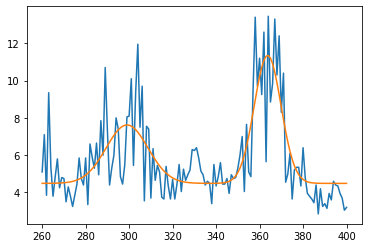

In [131]:
start = time.time()

tuneUp.configure_eODMR(fstart=260, fstop=400, pts=141, rp=20, trsh=5)

frequency = np.linspace(260, 400, 141)

ODMR_res = np.zeros(141)
for ii in range(141):
    ODMR_res[ii] = tuneUp.experiment_eODMR(frequency[ii])

peaks = vecODMRFit(frequency, ODMR_res)

print("Found ODMR peaks at " + str(peaks[0]) + " and " + str(peaks[1]))
print(time.time()-start)

tuning up first Rabi frequency
79.02893145232892
67.87743126384004
74.8695881197466
1st Rabi optimization done! First peak is at 299.0391725374075 for a pi time of 79.02893145232892
39.4897403717041


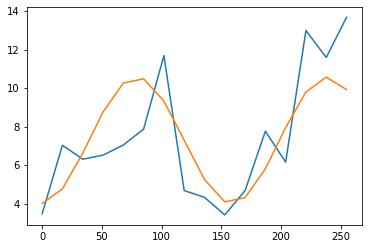

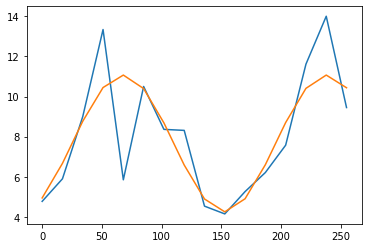

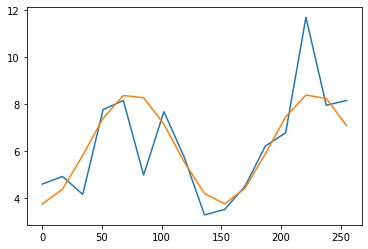

In [132]:
start = time.time()
print("tuning up first Rabi frequency")
tuneUp.configure_eRABI(f1=peaks[0]*1e6, f2=peaks[1]*1e6, p2=133, rp=80, tstop=255, pts=16)

t = np.linspace(0, 255, 16)

RABI = np.zeros(16)
for ii in range(16):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time = vecRabiFit(t, RABI)
print(pi_time)

hd.setd('oscs/0/freq', peaks[0]*1e6 + 2e6)
time.sleep(0.06)
for ii in range(16):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_up = vecRabiFit(t, RABI)
print(pi_time_up)

hd.setd('oscs/0/freq', peaks[0]*1e6 - 2e6)
time.sleep(0.06)
for ii in range(16):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_down = vecRabiFit(t, RABI)
print(pi_time_down)

opt_freq1 = peaks[0]

if np.argmax([pi_time_down, pi_time, pi_time_up]) == 1:
    pass
elif np.argmax([pi_time_down, pi_time, pi_time_up]) == 0:
    while (pi_time < pi_time_down):
        pi_time = pi_time_down
        opt_freq1 = opt_freq1 - 2
        hd.setd('oscs/0/freq', (opt_freq1 - 2)*1e6)
        time.sleep(0.06)
        for ii in range(16):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_down = vecRabiFit(t, RABI)
        print(pi_time_down)
else:
    while (pi_time < pi_time_up):
        pi_time = pi_time_up
        opt_freq1 = opt_freq1 + 2
        hd.setd('oscs/0/freq', (opt_freq1 + 2)*1e6)
        time.sleep(0.06)
        for ii in range(16):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_up = vecRabiFit(t, RABI)
        print(pi_time_up)

pi_time1 = pi_time

print("1st Rabi optimization done! First peak is at " + str(opt_freq1) + ' for a pi time of ' + str(pi_time1))
print(time.time()-start)

tuning up second Rabi frequency
129.95318103303904
133.63398020379358
133.73738489251886
120.33237246414873
2nd Rabi optimization done! First peak is at 372.18244922652093 for a pi time of 133.73738489251886


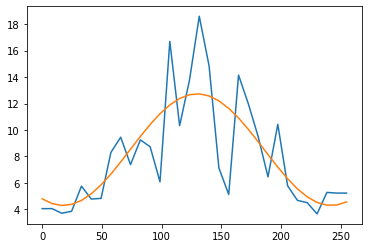

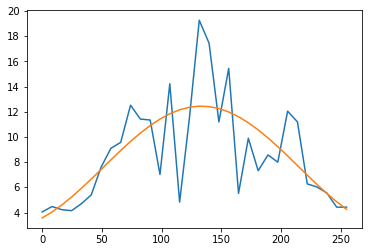

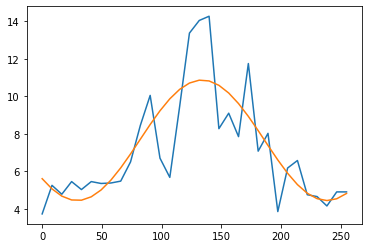

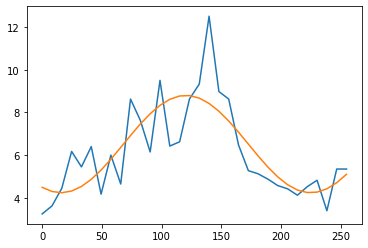

In [108]:
print("tuning up second Rabi frequency")
hd.setd('oscs/0/freq', peaks[1]*1e6)
hd.setd('oscs/1/freq', opt_freq1*1e6)
#tuneUp.configure_eRABI(f1=peaks[1], opt_freq1, 128, int(pi_time1), 5, 5)
N_points = 32
t = np.linspace(0, 255, N_points)

RABI = np.zeros(N_points)
for ii in range(N_points):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time = vecRabiFit(t, RABI)
print(pi_time)

hd.setd('oscs/0/freq', peaks[1]*1e6 + 2e6)
time.sleep(0.06)
for ii in range(N_points):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_up = vecRabiFit(t, RABI)
print(pi_time_up)

hd.setd('oscs/0/freq', peaks[1]*1e6 - 2e6)
time.sleep(0.06)
for ii in range(N_points):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_down = vecRabiFit(t, RABI)
print(pi_time_down)

opt_freq2 = peaks[1]

if np.argmax([pi_time_down, pi_time, pi_time_up]) == 1:
    pass
elif np.argmax([pi_time_down, pi_time, pi_time_up]) == 0:
    while (pi_time < pi_time_down):
        pi_time = pi_time_down
        opt_freq2 = opt_freq2 - 2
        hd.setd('oscs/0/freq', (opt_freq2 - 2)*1e6)
        time.sleep(0.06)
        for ii in range(N_points):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_down = vecRabiFit(t, RABI)
        print(pi_time_down)
else:
    while (pi_time < pi_time_up):
        pi_time = pi_time_up
        opt_freq2 = opt_freq2 + 2
        hd.setd('oscs/0/freq', (opt_freq2 + 2)*1e6)
        time.sleep(0.06)
        for ii in range(N_points):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_up = vecRabiFit(t, RABI)
        print(pi_time_up)

pi_time2 = pi_time

print("2nd Rabi optimization done! First peak is at " + str(opt_freq2) + ' for a pi time of ' + str(pi_time2))


In [ ]:


tuneUp.configure_eODMR()

frequency = np.linspace(315, 355, 141)

ODMR_res = np.zeros(141)
for ii in range(141):
    ODMR_res[ii] = tuneUp.experiment_eODMR(frequency[ii])

peaks = vecOdmrFit(frequency, ODMR_res)

print("found ODMR peaks at " + str(peaks[0]) + " and " + str(peaks[1]))

print("tuning up first Rabi frequency")
tuneUp.configure_eRABI(f1=peaks[0], f2=peaks[1])

t = np.linspace(0, 255, 256)

RABI = np.zeros(256)
for ii in range(256):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time = vecRabiFit(t, RABI)

hd.setd('osc/0/freq', peaks[0]*1e6 + 1e6)
time.sleep(0.06)
for ii in range(256):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_up = vecRabiFit(t, RABI)

hd.setd('osc/0/freq', peaks[0]*1e6 - 1e6)
time.sleep(0.06)
for ii in range(256):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_down = vecRabiFit(t, RABI)

opt_freq1 = peaks[0]

if np.argmax([pi_time_down, pi_time, pi_time_up]) == 1:
    pass
elif np.argmax([pi_time_down, pi_time, pi_time_up]) == 0:
    while (pi_time < pi_time_down):
        pi_time = pi_time_down
        opt_freq1 = opt_freq1 - 1
        hd.setd('osc/0/freq', (opt_freq1 - 1)*1e6)
        time.sleep(0.06)
        for ii in range(256):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_down = vecRabiFit(t, RABI)
else:
    while (pi_time < pi_time_up):
        pi_time = pi_time_down
        opt_freq1 = opt_freq1 + 1
        hd.setd('osc/0/freq', (opt_freq1 + 1)*1e6)
        time.sleep(0.06)
        for ii in range(256):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_up = vecRabiFit(t, RABI)

pi_time1 = pi_time

print("1st Rabi optimization done! First peak is at " + str(opt_freq1) + ' for a pi time of ' str(pi_time1))

print("tuning up second Rabi frequency")
tuneUp.configure_eRABI(f1=peaks[1], opt_freq1, 128, int(pi_time1), 5, 5)

t = np.linspace(0, 255, 256)

RABI = np.zeros(256)
for ii in range(256):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time = vecRabiFit(t, RABI)

hd.setd('osc/0/freq', peaks[1]*1e6 + 1e6)
time.sleep(0.06)
for ii in range(256):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_up = vecRabiFit(t, RABI)

hd.setd('osc/0/freq', peaks[1]*1e6 - 1e6)
time.sleep(0.06)
for ii in range(256):
    RABI[ii] = tuneUp.experiment_eRABI(t[ii])

pi_time_down = vecRabiFit(t, RABI)

opt_freq2 = peaks[1]

if np.argmax([pi_time_down, pi_time, pi_time_up]) == 1:
    pass
elif np.argmax([pi_time_down, pi_time, pi_time_up]) == 0:
    while (pi_time < pi_time_down):
        pi_time = pi_time_down
        opt_freq2 = opt_freq2 - 1
        hd.setd('osc/0/freq', (opt_freq2 - 1)*1e6)
        time.sleep(0.06)
        for ii in range(256):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_down = vecRabiFit(t, RABI)
else:
    while (pi_time < pi_time_up):
        pi_time = pi_time_down
        opt_freq2 = opt_freq2 + 1
        hd.setd('osc/0/freq', (opt_freq2 + 1)*1e6)
        time.sleep(0.06)
        for ii in range(256):
            RABI[ii] = tuneUp.experiment_eRABI(t[ii])

        pi_time_up = vecRabiFit(t, RABI)

pi_time2 = pi_time

print("2nd Rabi optimization done! First peak is at " + str(opt_freq2) + ' for a pi time of ' str(pi_time2))


In [33]:
vecODMRFit(frequency, ODMR_res)

[2.25, 2.25, 328.42857142857144, 341.85714285714283, 8.875, 8.875, 5.525]
([1, 1, 315.0, 315.0, 1.775, 1.775, 3.6833333333333336], [7.775, 7.775, 355.0, 355.0, 23.666666666666668, 23.666666666666668, 11.662500000000001])


[322.33512997298135, 353.67694895605274]